### Visualisation Notebook
This notebook serves as a comprehensive resource for generating plots featured in the manuscript, as well as providing additional visualizations for data analysis and interpretation.

Key points include:

- All scripts used to produce the manuscript's plots are included in this notebook.
- Additional plots are available to facilitate further exploration and analysis of the data.
- The code for the plotting functions is modularized and stored separately in the plotting_functions.py file for ease of use and maintenance.


In [ ]:

#This two functions are used to get the number of fragments per group and the top fragments per group for each library

import pandas as pd

def get_fragments_per_group(df_list: list, library_names: list, group_col: str, count_col) -> pd.DataFrame:
    new_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        # add the number of unique elements from the count column with each group
        new_row = df.groupby(group_col).agg({count_col: 'nunique'}).reset_index()
        # rename count column
        new_row.rename(columns={count_col: 'count'}, inplace=True)
        new_row['library'] = library_names[i]
        new_df = pd.concat([new_df, new_row])
        
    # Sort the dataframe by the count column
    new_df.sort_values(by='count', ascending=False, inplace=True)
        
    return new_df


def get_top_fragments_per_group(df_list: list, library_names: list, group_col: str, value_col:str, number_of_top: int=10) -> pd.DataFrame:
    new_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        df['library'] = library_names[i]
        df = df[[group_col, value_col, 'library','LUTnr', 'Peptide', 'Sequence']]
        new_df = pd.concat([new_df, df])
    new_df.sort_values(by=[group_col,value_col], ascending=[True,False], inplace=True)
    # add the number of top number of rows with the highest values from the value column with each group
    temp_df = new_df.groupby(group_col).apply(lambda x: x.nlargest(number_of_top, value_col)).reset_index(drop=True)
        
    # Sort the dataframe by the count column
    temp_df.sort_values(by=[group_col,value_col], ascending=[True,False], inplace=True)
    
    return temp_df

In [ ]:
# Read the dataframes into dataframes

import pandas as pd

df_p005 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p005_no_starcode/final_fragments_summary.csv")
df_p006 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p006_no_starcode/final_fragments_summary.csv")
df_p007 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p007_no_starcode/final_fragments_summary.csv")
brave_14aa = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/Brave/final_fragments_summary.csv")
brave_22aa = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/Brave_22aa/final_fragments_summary.csv")

In [ ]:
# Here we are using the plotting function that we have created to plot the number of fragments per group for each library

from plotting_functions import create_grouped_barplot

count_df = get_fragments_per_group([df_p005, df_p006, df_p007], ['p005', 'p006', 'p007'], 'Group', 'Peptide')

plot = create_grouped_barplot(count_df, 'Group', 'count', 'library')

# save the plot as a png file without background
plot.savefig("plots/librarys/fragments_per_tissue_comparison.png", dpi=600, bbox_inches='tight', transparent=True)

### Library-Specific Plots
This section focuses on generating plots tailored to specific libraries. The visualizations can be customized by selecting different datasets (dataframes) representing the libraries. Users can modify the code to switch between libraries as needed, enabling flexibility in analysis and presentation.

In [ ]:
# Selecting the data that we want to use for the plot

df = df_p005

# cehck if the Origion_seq column exists
if 'Origion_seq' in df.columns:
    # for p005 we can extract the GeneName from the Origion_seq column
    if df['Origion_seq'].str.contains(',').any():
        df['GeneName'] = df['Origion_seq'].str.split(',').str[5]

In [ ]:
# Here we are using the plotting function that we have created to plot the number of fragments per group for each library to show the distribution of fragments in each group

from plotting_functions import plot_quantities

name = "p006"
array = {"p005": 41980, "p006": 600000, "p007": 117126, "brave_14": 44813, "brave_22": 16100}

if name == "p006":
    plot = plot_quantities(df,
                    {'Plasmid_Library':'Plasmid Library', 'DNAse_resistant_AAVs':'DNAse res.', 'Infective_AAVs': '*Inf AAVs'},
                    {"Array": array[name]})
else:
    plot = plot_quantities(df,
                    {'Plasmid_Library':'Plasmid Library', 'DNAse_resistant_AAVs':'DNAse resistant AAVs', 'Infective_AAVs': 'Inf AAVs'},
                    {"Array": array[name]})

plot.savefig(f"plots/librarys/{name}_quantities.png", dpi=600, bbox_inches='tight', transparent=True)

In [ ]:
# Here we are using the plotting function that we have created to plot with the read count ratio for the top fragments in a specific group

from plotting_functions import plot_top_counts

plot_top_counts(df, 100, 'Infective_AAVs', 'BC_count')

In [ ]:
# Here we are getting an overview of the unique group names and gene names in the dataframe

# print all unique group names
print(df['Group'].unique())
# print all unqiue gene names
print(df['GeneName'].unique())

In [ ]:
# Here we are plotting the normalized RNA counts comparison between two gropus accros a specific gene reference

from plotting_functions import plot_rna_counts
import numpy as np

df['normalized_RNAcount'] = np.log2(df['RNAcount']+1)
p = plot_rna_counts(df, "Plasmid_Library", "Infective_AAVs", "HSV-1-pUL1", "RNAcount", "RNA count", normalize=True)
# Save the plot as a png file without background
p.savefig("plots/p005/p005_HSV-1-puL1_Infective.png", dpi=600, bbox_inches='tight', transparent=True)

p = plot_rna_counts(df, "Plasmid_Library", "DNAse_resistant_AAVs", "HSV-1-pUL1", "RNAcount", "RNA count", normalize=True)
# Save the plot as a png file without background
p.savefig("plots/p005/p005_HSV-1-puL1_DNAse.png", dpi=600, bbox_inches='tight', transparent=True)


In [14]:
# Here is a function that is used to get the top fragments for a specific group and structure

def get_top_fragment(df, group, n, sort_by, strucutre=None):
    if strucutre is None:
        return df[df['Group'] == group].nlargest(n, sort_by)
    else:
        return df[(df['Group'] == group) & (df['Structure'] == strucutre)].nlargest(n, sort_by)

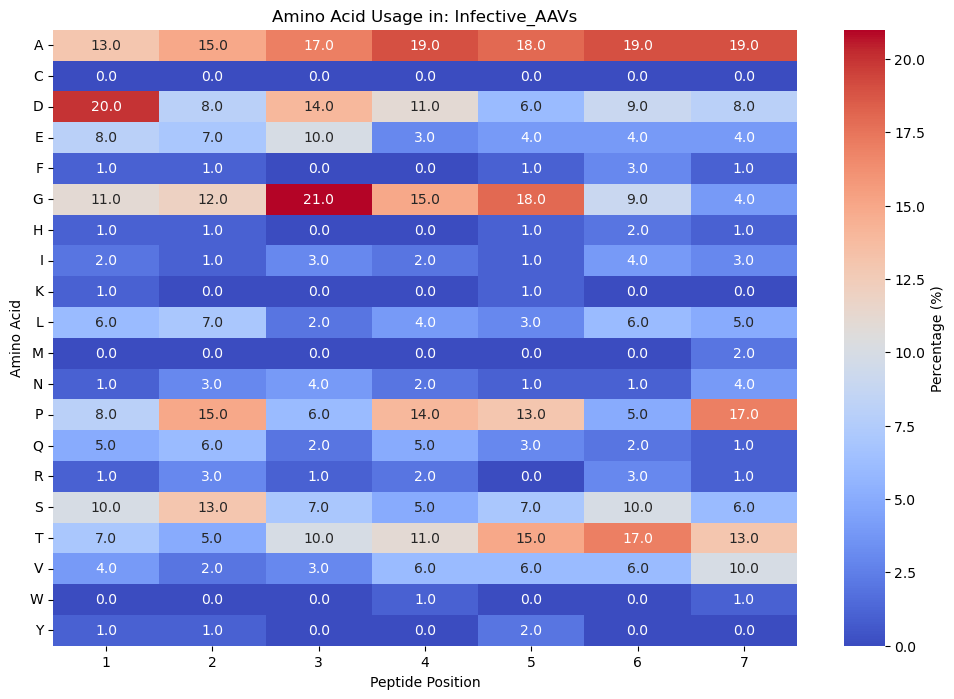

In [28]:
# here we are plotting the heatmap for amino acid usage for a specific group
from plotting_functions import plot_amino_acid_heatmap

# Here we are using the function to get the top 50 fragments for a specific group and structure
df = df_p005
top_100_inf_aavs = get_top_fragment(df, "Infective_AAVs", 100, "BC_count")

plot = plot_amino_acid_heatmap(top_100_inf_aavs, "Infective_AAVs")

# Save the plot as a png file without background
plot.savefig("plots/heatmaps/p005_Infective_AAVs_amino_acid_heatmap.png", dpi=600, bbox_inches='tight', transparent=True)

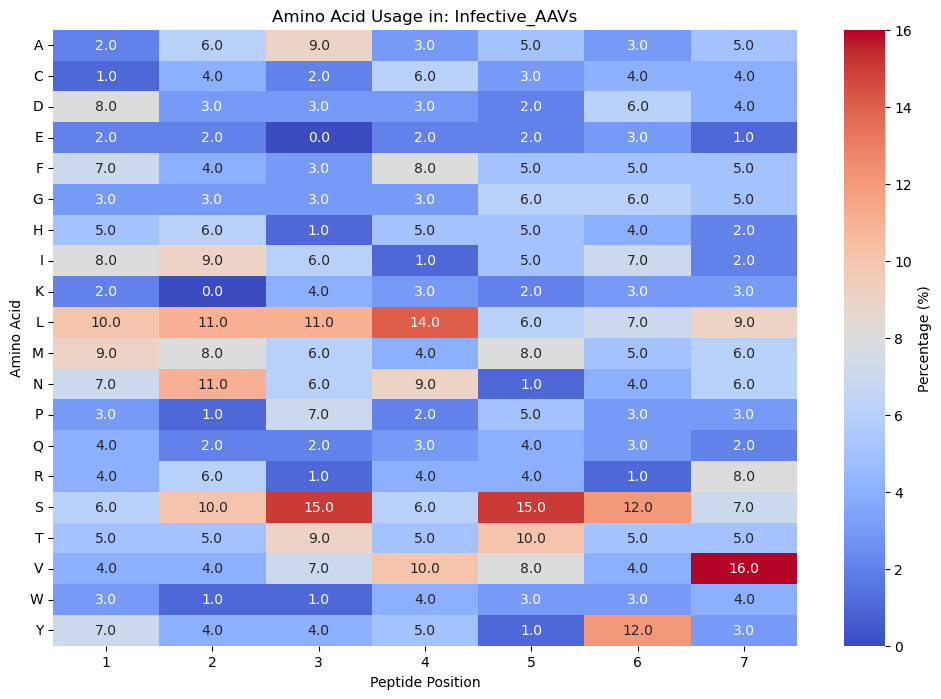

In [29]:
# here we are plotting the heatmap for amino acid usage for a specific group
from plotting_functions import plot_amino_acid_heatmap

# Here we are using the function to get the top 50 fragments for a specific group and structure
df = df_p006
top_100_inf_aavs = get_top_fragment(df, "Infective_AAVs", 100, "BC_count")

plot_amino_acid_heatmap(top_100_inf_aavs, "Infective_AAVs")

# Save the plot as a png file without background
plot.savefig("plots/heatmaps/p006_Infective_AAVs_amino_acid_heatmap.png", dpi=600, bbox_inches='tight', transparent=True)

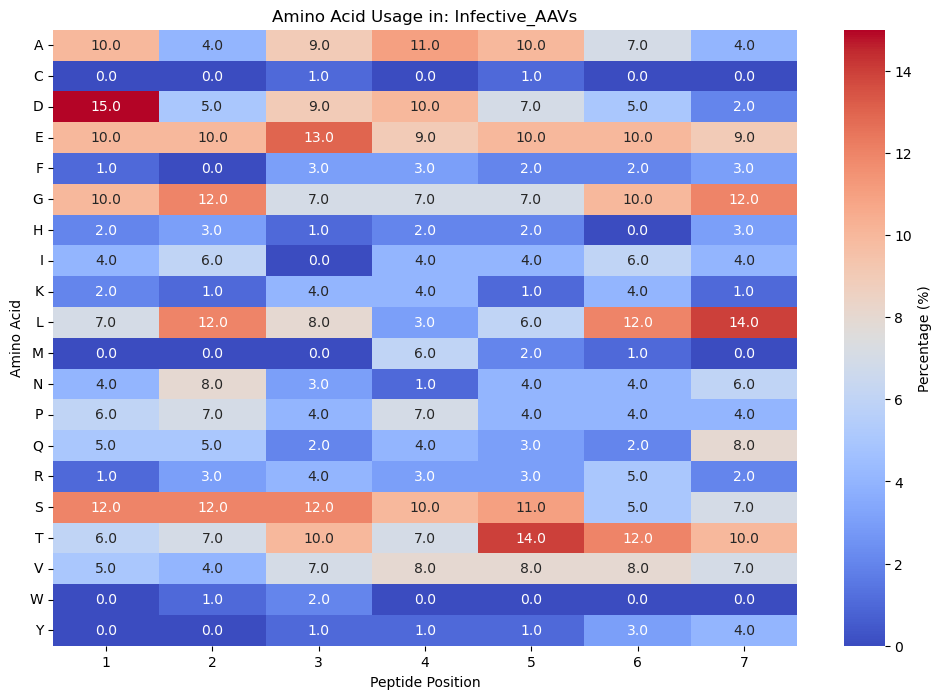

In [30]:
# here we are plotting the heatmap for amino acid usage for a specific group
from plotting_functions import plot_amino_acid_heatmap

# Here we are using the function to get the top 50 fragments for a specific group and structure
df = df_p007
top_100_inf_aavs = get_top_fragment(df, "Infective_AAVs", 100, "BC_count")

plot_amino_acid_heatmap(top_100_inf_aavs, "Infective_AAVs")

# Save the plot as a png file without background
plot.savefig("plots/heatmaps/p007_Infective_AAVs_amino_acid_heatmap.png", dpi=600, bbox_inches='tight', transparent=True)